# Reproduction of Deep auto-encoder based clustering by Song et al.

The reference for this paper is :

```bibtex
@article{Song2014DeepAB,
  title={Deep auto-encoder based clustering},
  author={Chunfeng Song and Yongzhen Huang and Feng Liu and Zhenyu Wang and Liang Wang},
  journal={Intell. Data Anal.},
  year={2014},
  volume={18},
  pages={S65-S76}
}
```

This is a TensorFlow reimplementation of the deep auto-encoder method for clustering presented by Song et al. in 2014.
The method is tested on MNIST and compared to the results reported in the paper.

Sadly, for now, the results are not reproduced.

In [1]:
# Necessary imports
from typing import List
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import importlib
import sys
from song_network import AutoencoderSong

2021-12-16 11:49:13.612487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/malcolm/ros_catkin_ws/noetic_ws/devel/lib:/usr/lib64/ros/lib
2021-12-16 11:49:13.612532: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We import MNIST dataset and separate it in training and test.

In [2]:
(ds_train_original, ds_test_original), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2021-12-16 11:49:19.178187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/malcolm/ros_catkin_ws/noetic_ws/devel/lib:/usr/lib64/ros/lib
2021-12-16 11:49:19.178227: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-16 11:49:19.178258: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2021-12-16 11:49:19.178641: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Once the dataset is loaded, we generate the batches that will be used for training and normalize the input.
We use a batch size of 2014 images.

In [3]:
batch_size = 2014


def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label


ds_train_original = ds_train_original.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train_original.cache()
ds_train = ds_train.shuffle(
    ds_info.splits["train"].num_examples, reshuffle_each_iteration=False
)
# replace labels by image itself for decoder/encoder
ds_train = ds_train.batch(batch_size).map(lambda x, _: (x, x))
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test_original = ds_test_original.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
)
ds_test = ds_test_original.batch(batch_size).map(lambda x, _: (x, x))
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

Run this cell if modifications have been done on LossClusteringSong or AutoEncoderSong to update the implementation in the notebook

In [4]:
importlib.reload(sys.modules["song_loss"])
from song_loss import LossClusteringSong, Centroid
from song_network import AutoencoderSong

Compile the network used for clustering. As described in the paper, it is an auto-encoder with 7 internal layers: 1000 -> 250 -> 50 -> 10 -> 50 -> 250 -> 1000.

The network update is sequential:
1) First, the encoder (and not the decoder) is trained while the centroids are fixed.
2) After on epoch of training, the centroids' positions are updated according to the samples they were associated with in the previous step.
3) Once the centroids have been updated, each sample is reassigned to the closest centroid. We go back to step 1.

In [6]:
latent_dim = 10

autoencoder = AutoencoderSong(latent_dim, (28, 28, 1), 0)

autoencoder.compile(
    optimizer="adam",
    # loss=loss,
    run_eagerly=True,
)

csv_logger = tf.keras.callbacks.CSVLogger("training.log", append=True)

Plotting methods to observe the results

In [8]:
import matplotlib.pyplot as plt


def plot(el: tf.Tensor):
    encoded_img = autoencoder.encoder(el)
    decoded_img = autoencoder.decoder(encoded_img)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(el[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_img[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


def plot_one(el: tf.Tensor):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(el[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


def plot_centroids(centroids: List[np.ndarray]):
    centroids_array = np.array(centroids)
    decoded_c = autoencoder.decoder(centroids_array)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # # display cluster
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_c[i])
        plt.title("clusters")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


def plot_associated_centroid(element: np.ndarray, index: int):
    centroid = autoencoder.song_loss.centroids.get_assigned_centroid(index)
    print(centroid)
    decoded_c = autoencoder.decoder(np.array([centroid]))
    plt.figure(figsize=(20, 4))
    ax = plt.subplot(3, 2, 1)
    plt.imshow(element)
    plt.title("element")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, 2, 2)
    plt.imshow(decoded_c[0])
    plt.title("centroid")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

We start by training the network as a _normal_ auto-encoder with no clustering.
This is done so that the decoder has a good idea of what its inputs/output should look like compared to a random initialization of its values.

Indeed, the decoder **cannot** be trained during the clustering training: training the decoder and the encoder at the same time will change the centroids during the encoder optimization, while the optimization of centroids and encoder must be separated.
Each centroid corresponds to a vector of 10 values (the middle part of the auto-encoder) and should always output the same image when passed through the decoder while the encoder is being trained.
Thus, we first train the auto-encoder as usual, then we freeze the decoder part, and retrain the encoder to perform clustering.

In [9]:
history = autoencoder.fit(
    ds_train,
    epochs=10,
    shuffle=True,
    callbacks=[csv_logger],
    validation_data=ds_test,
)

Epoch 1/10
30/30 [==============================] - 16s 517ms/step - loss: 0.1070 - val_loss: 0.0749
Epoch 2/10
30/30 [==============================] - 12s 396ms/step - loss: 0.0710 - val_loss: 0.0648
Epoch 3/10
30/30 [==============================] - 12s 402ms/step - loss: 0.0598 - val_loss: 0.0543
Epoch 4/10
30/30 [==============================] - 13s 414ms/step - loss: 0.0481 - val_loss: 0.0417
Epoch 5/10
30/30 [==============================] - 12s 391ms/step - loss: 0.0393 - val_loss: 0.0360
Epoch 6/10
30/30 [==============================] - 12s 391ms/step - loss: 0.0350 - val_loss: 0.0331
Epoch 7/10
30/30 [==============================] - 13s 431ms/step - loss: 0.0331 - val_loss: 0.0314
Epoch 8/10
30/30 [==============================] - 14s 457ms/step - loss: 0.0309 - val_loss: 0.0296
Epoch 9/10
30/30 [==============================] - 16s 546ms/step - loss: 0.0297 - val_loss: 0.0285
Epoch 10/10
30/30 [==============================] - 10s 339ms/step - loss: 0.0279 - val_lo

Illustration plot of ten images and the ten centroids before optimization of the clusters.

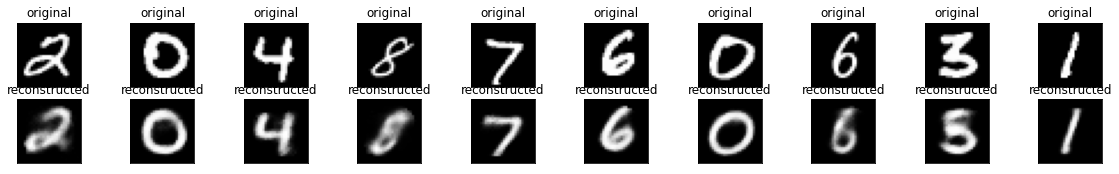

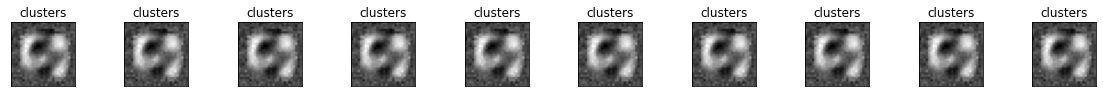

In [10]:
iterator = iter(ds_test)
el = iterator.get_next()[0]
plot(el)
plot_centroids(autoencoder.song_loss.centroids.centroids)

Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20
AF [6045, 5954, 6026, 5930, 6060, 6061, 5978, 6081, 5942, 5923]


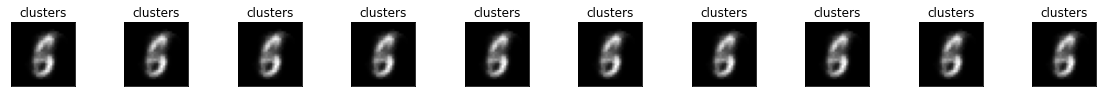

In [11]:

autoencoder.song_loss.init_centroids()
for count_sum, element in enumerate(ds_train):
    if count_sum % 10 == 0:
        print("Step", count_sum)
    autoencoder.song_loss.sum_centroids(element[0], count_sum)

autoencoder.song_loss.update_centroids()

for count_update, element in enumerate(ds_train):
    if count_update % 10 == 0:
        print("Step assignement", count_update)
    autoencoder.song_loss.update_assignments(element[0], count_update)

print("AF", autoencoder.song_loss.centroids.associated_features)
plot_centroids(autoencoder.song_loss.centroids.centroids)

We freeze the decoder and set the lambda parameter to the value indicated in the paper for MNIST.

In [12]:
autoencoder.song_loss.lambda_t = 0.1
autoencoder.freeze_decoder()

We do the sequential training over 10 epochs.
First the encoder is trained while the centroids are fixed.
Then the centroids are updated to the means of the position of their samples.
Finally, the sample assignments to centroids are updated.

Try nb 0
Step 0
Step 10
Step 20
Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20


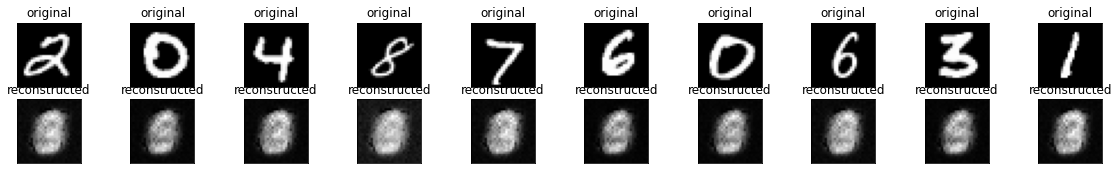

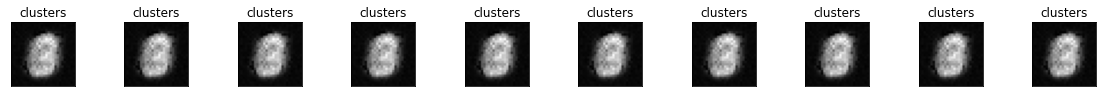

Try nb 1
Step 0
Step 10
Step 20
Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20


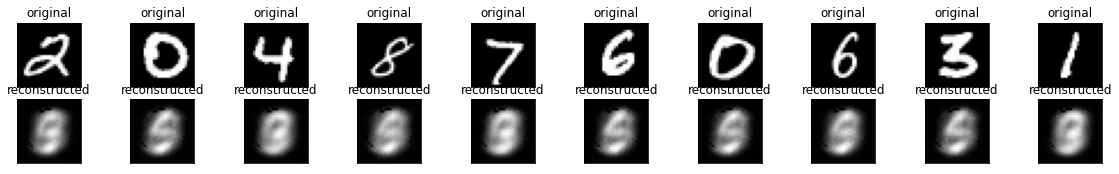

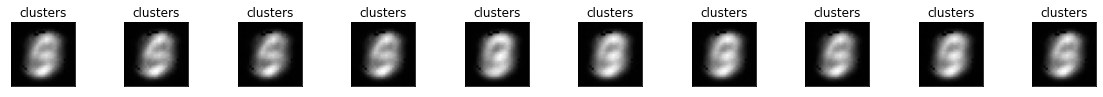

Try nb 2
Step 0
Step 10
Step 20
Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20


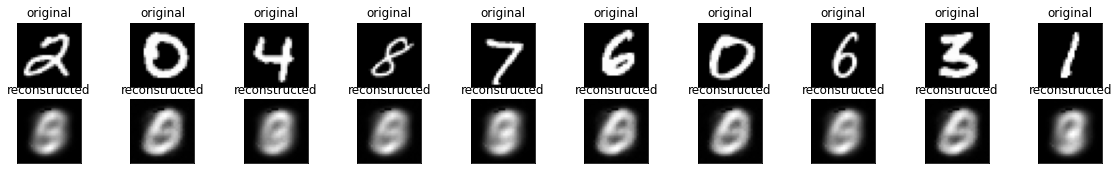

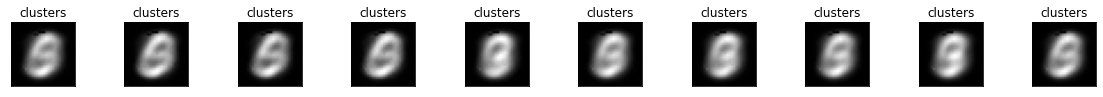

Try nb 3
Step 0
Step 10
Step 20
Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20


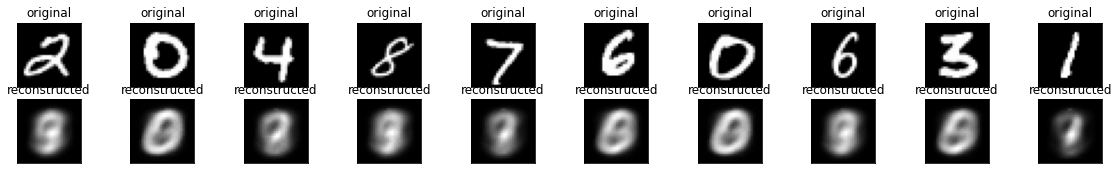

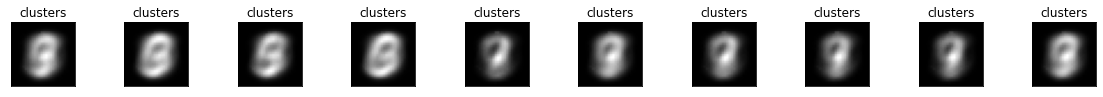

Try nb 4
Step 0
Step 10
Step 20
Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20


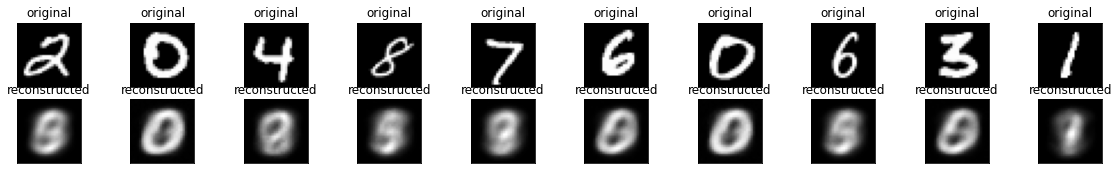

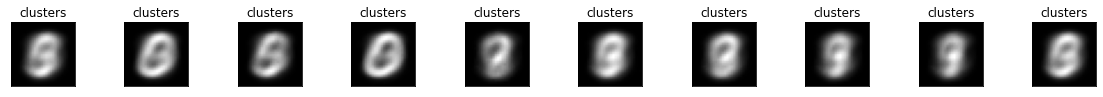

Try nb 5
Step 0
Step 10
Step 20
Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20


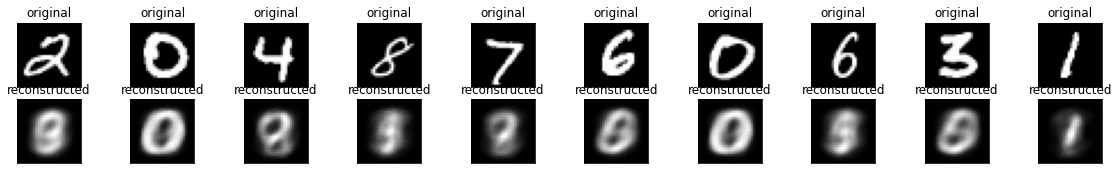

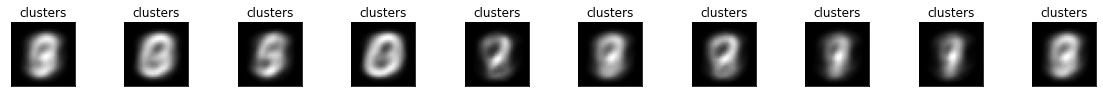

Try nb 6
Step 0
Step 10
Step 20
Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20


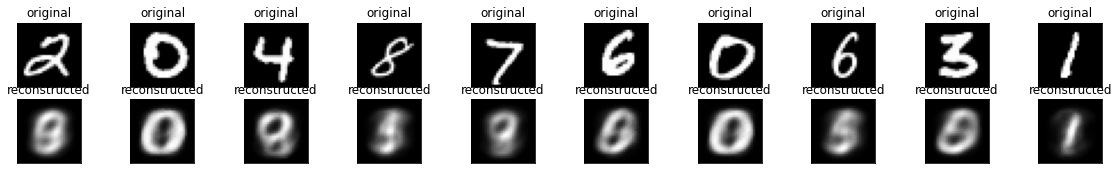

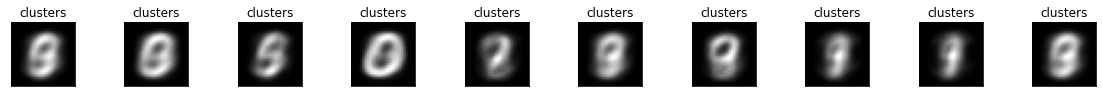

Try nb 7
Step 0
Step 10
Step 20
Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20


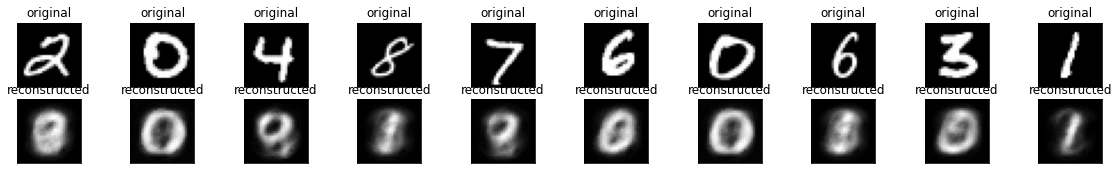

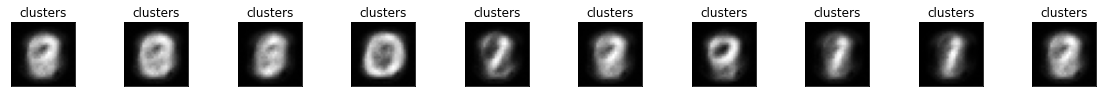

Try nb 8
Step 0
Step 10
Step 20
Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20


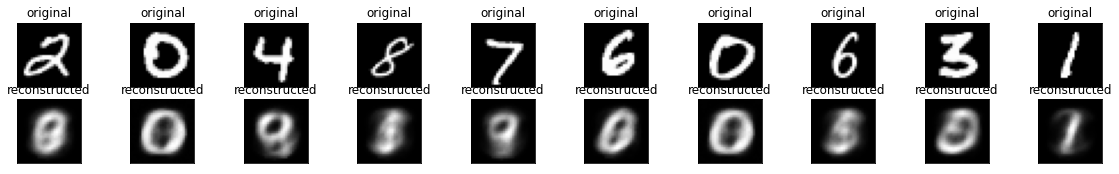

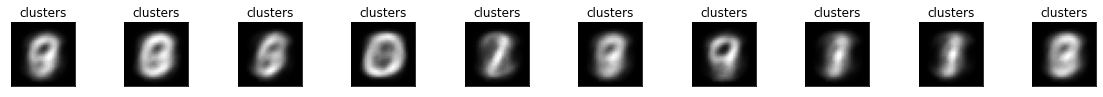

Try nb 9
Step 0
Step 10
Step 20
Step 0
Step 10
Step 20
Step assignement 0
Step assignement 10
Step assignement 20


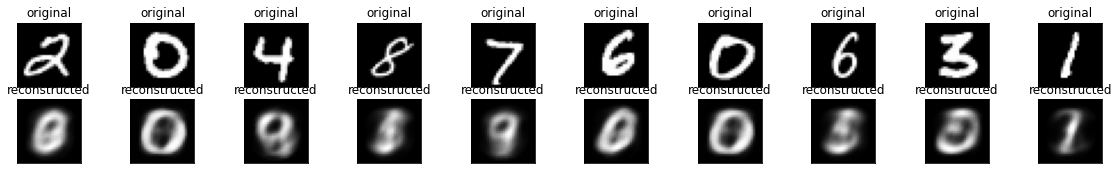

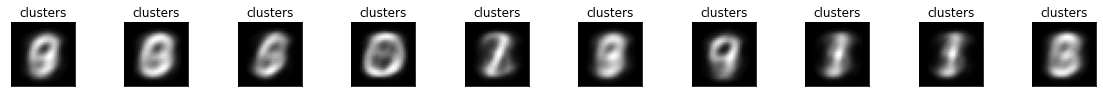

In [13]:
n = 10
for i in range(n):
    print("Try nb", i)
    for count_sum, element in enumerate(ds_train):
        if count_sum % 10 == 0:
            print("Step", count_sum)
        history = autoencoder.fit(
            x=element[0],
            y=element[1],
            batch_size=batch_size,
            verbose=0,
            # epochs=1,
            shuffle=False,
            callbacks=[csv_logger],
            validation_data=ds_test,
        )
    autoencoder.step = 0

    # Update centroids
    autoencoder.song_loss.init_centroids()
    for count_sum, element in enumerate(ds_train):
        if count_sum % 10 == 0:
            print("Step", count_sum)
        autoencoder.song_loss.sum_centroids(element[0], count_sum)

    autoencoder.song_loss.update_centroids()

    for count_update, element in enumerate(ds_train):
        if count_update % 10 == 0:
            print("Step assignement", count_update)
        autoencoder.song_loss.update_assignments(element[0], count_update)

    plot(el)
    plot_centroids(autoencoder.song_loss.centroids.centroids)

Sadly, as seen in the results above, the cluster do not converge as quick and accurately as reported in the paper.
PR are welcome to try to obtain the correct results if there is an error in my implementation.

Running the optimization 100 times leads to some slightly clearer clusters but not the correct one.
For 100 runs we obtain:
<img src="results/100.png"> 